In [1]:
import os
os.environ['TF_ENABLE_TENSORRT']='1'
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] ='false'
import tensorflow as tf
from tensorflow import keras
from keras.layers import(Conv2D,MaxPool2D,Conv2DTranspose,concatenate,Dropout,Input,Lambda)
from keras.models import Model
from keras.utils import Sequence
import matplotlib.pyplot as plt
import psutil
import sys

import PIL
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
#print("cuDNN version",tf.config.list_physical_devices('GPU'))

2023-09-14 17:23:04.248463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 17:23:04.900767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)


2023-09-14 17:23:06.758524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 17:23:06.778206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 17:23:06.778358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:

# Create ImageDataGenerator instances for images and masks
image_datagen = ImageDataGenerator(rescale=1/255.,
                                )
mask_datagen = ImageDataGenerator(rescale=1/255.,
                              
                                )

# Define the image and mask generators using flow_from_directory
batch_size = 8

# Use the same seed for image and mask generators to ensure they apply the same transformations
seed = 42

train_image_generator = image_datagen.flow_from_directory(
    '/home/sbagh/Documents/UNet_Detection/datasets/trainset_081023/train_images/',
    target_size = (256,256),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    color_mode='rgb'
    
    
    
)

train_mask_generator = mask_datagen.flow_from_directory(
    '/home/sbagh/Documents/UNet_Detection/datasets/trainset_081023/train_masks/',
    target_size =(256,256),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    color_mode='grayscale'
    
    
)

val_image_generator = image_datagen.flow_from_directory(
    '/home/sbagh/Documents/UNet_Detection/datasets/trainset_081023/val_images/',
    target_size = (256,256),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    color_mode='rgb'
    
    
)

val_mask_generator = mask_datagen.flow_from_directory(
    
    '/home/sbagh/Documents/UNet_Detection/datasets/trainset_081023/val_masks/',
    target_size = (256,256),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    color_mode='grayscale'
    
    
)

test_image_generator = image_datagen.flow_from_directory(
    '/home/sbagh/Documents/UNet_Detection/datasets/trainset_081023/test_images/',
    target_size = (256,256),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    color_mode='rgb'
   
    
)

test_mask_generator = mask_datagen.flow_from_directory(
    '/home/sbagh/Documents/UNet_Detection/datasets/trainset_081023/test_masks/',
    target_size = (256,256),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    color_mode='grayscale'
    

)

# Combine image and mask generators using zip
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)



Found 4916 images belonging to 1 classes.
Found 4916 images belonging to 1 classes.
Found 547 images belonging to 1 classes.
Found 547 images belonging to 1 classes.
Found 607 images belonging to 1 classes.
Found 607 images belonging to 1 classes.


In [ ]:
# Checking the outputs of data generators are correct

x,y= next(train_generator)

for i in range(0,1):
    image = x[i]
    mask=y[i]
    plt.subplot(3,1,1)
    plt.imshow(image[:,:,0],cmap='gray')
    plt.subplot(3,1,2)
    plt.imshow(mask[:,:,0])
    plt.subplot(3,1,3)
    plt.imshow(y[i])
    plt.show()

print(x.dtype)
data = np.asarray(x)
print(data)
print(data.dtype)
print(data.max())
print(data.shape)


data1 = np.asarray(mask)
print(data1)
print(data1.dtype)
print(data1.max())
print(data1.shape)

In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda,Flatten
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)    
    x = Activation("relu")(x)
    # x = Dropout(0.2)(x)
    
    

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)
    
   

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    
    return x, p   

#Decoder block


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge
    # b1 = conv_block(p2, 1024) #Bridge

    # d1 = decoder_block(b1, s2, 128)
    # d2 = decoder_block(d1, s1, 64)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [5]:
from keras import backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull ffloat32
255.0
(1, 256, 256, 1)or unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

#Dice metric

def dice_metric(y_pred,y_true):
    intersection = K.sum(K.sum(K.abs(y_true*y_pred),axis=-1))
    union = K.sum(K.sum(K.abs(y_true)+K.abs(y_pred),axis=-1))

    return 2*intersection/union

from focal_loss import BinaryFocalLoss

In [6]:
input_shape = (256,256,3)
model = build_unet(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001),loss= BinaryFocalLoss(gamma=4),metrics=['accuracy',dice_metric])
model.summary()

2023-09-14 17:23:25.630729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 17:23:25.630999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 17:23:25.631157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

In [ ]:
tf.keras.utils.plot_model(model, "model.png")

In [7]:
#model checkpoint

checkpointer=tf.keras.callbacks.ModelCheckpoint('joint_model.h5',verbose=1,save_best_only=True)
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4,monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

num_train_imgs = len(os.listdir('/home/sbagh/Documents/UNet_Detection/datasets/trainset_081023/train_images/train/'))
num_val_imgs = len(os.listdir('/home/sbagh/Documents/UNet_Detection/datasets/trainset_081023/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps = num_val_imgs//batch_size
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
for epoch in range(100):
    
    history = model.fit(train_generator,steps_per_epoch=steps_per_epoch,validation_data=val_generator,validation_steps=val_steps)
    train_loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])
    train_acc.extend(history.history['accuracy'])
    val_acc.extend(history.history['val_accuracy'])
    tf.keras.backend.clear_session()

2023-09-14 17:23:51.439564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-14 17:23:54.391410: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5ba070caf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-14 17:23:54.391429: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-09-14 17:23:54.395228: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-14 17:23:54.484236: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


614/614 [==============================] - 130s 210ms/step - loss: 7.3647e-05 - accuracy: 0.9995 - dice_metric: 0.8125 - val_loss: 7.1394e-04 - val_accuracy: 0.9986 - val_dice_metric: 0.7757


In [ ]:
model.save("jointsmodel_unet.h5")

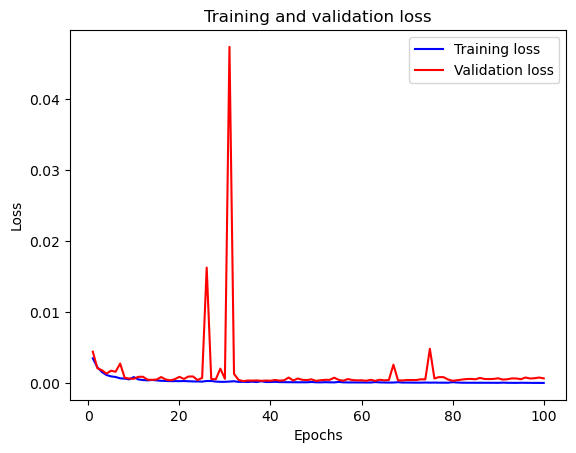

In [8]:
#plot the training and validation accuracy and loss at each epoch

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

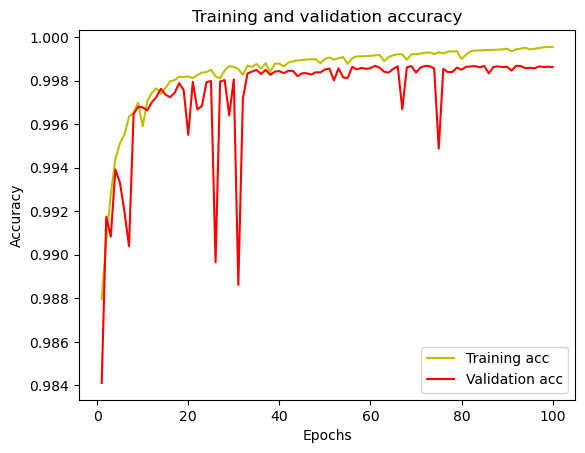

In [9]:

plt.plot(epochs, train_acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

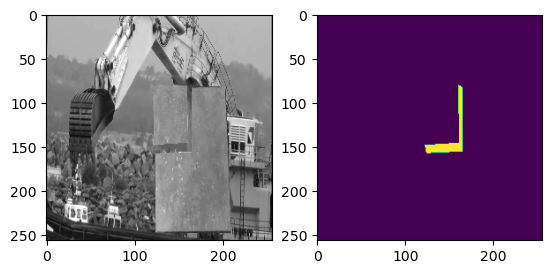

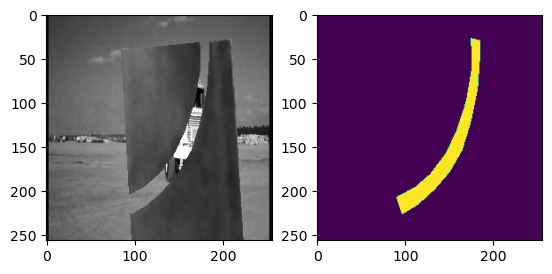

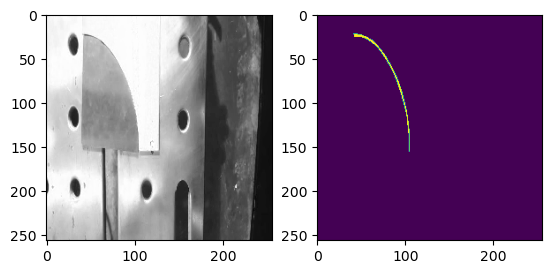

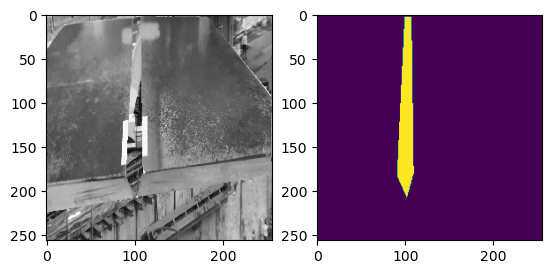

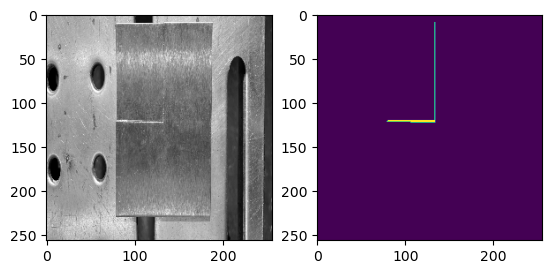

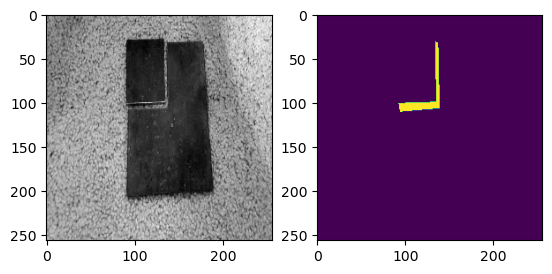

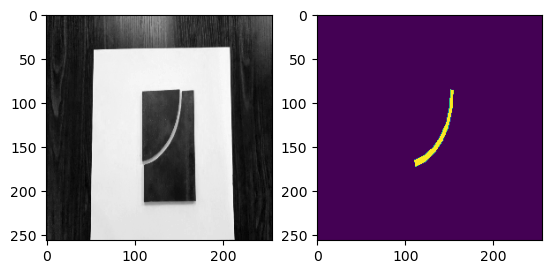

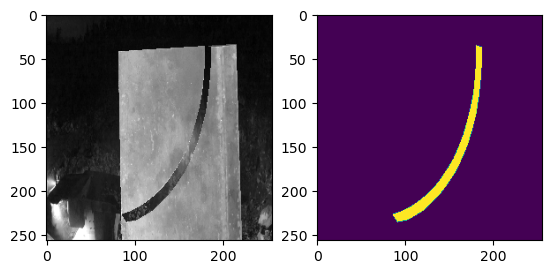

1/1 [==============================] - 0s 17ms/step


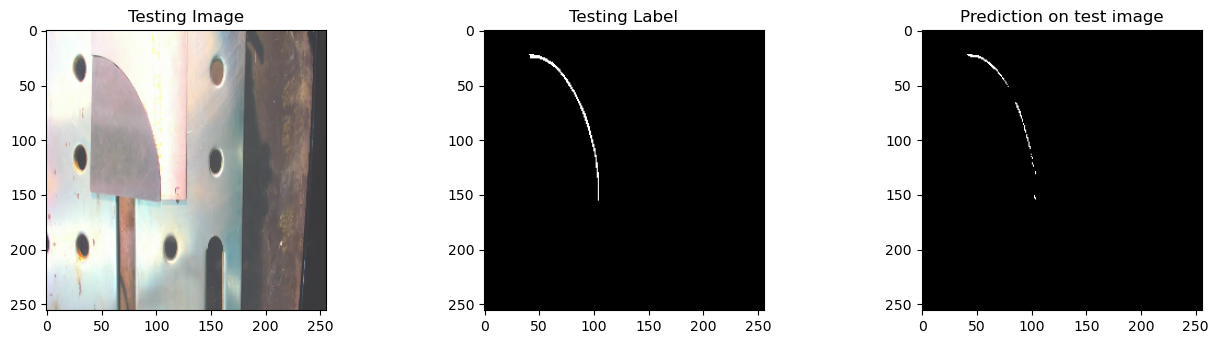

In [16]:
### Testing on a few test images

a = test_image_generator.next()
b = test_mask_generator.next()
for i in range(len(a)):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

    

import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[2]
ground_truth=b[2]
#test_img_norm=test_img[:,:,0][:,:,None]
# test_image = np.asarray(test_img)
# print(test_image.dtype)
# print(test_image.shape)
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

Found 3 images belonging to 1 classes.
1/1 [==============================] - 0s 16ms/step


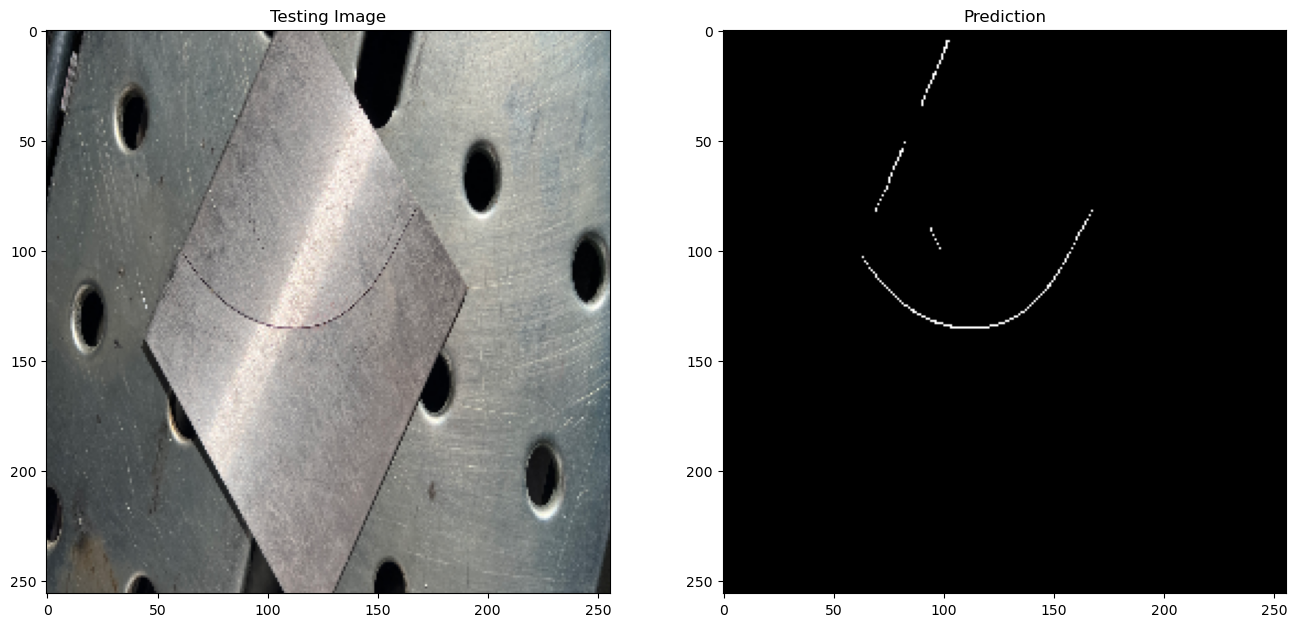

In [14]:
test1_image_generator = image_datagen.flow_from_directory(
    '/home/sbagh/Documents/UNet_Detection/datasets/trainset_test/',
    target_size = (256,256),
    batch_size=batch_size,
    class_mode=None,
    seed=seed
    
    
    
)


# new_size= (256,256)
# test_img = Image.open("/home/sbagh/Documents/UNet_Detection/datasets/trainset_081023/test_images/test/image161.png")
# test_img = test_img.resize(new_size)
# test_img = np.asarray(test_img)
# print(test_img.shape)
# test_img_input=np.expand_dims(test_img, 0)

test_img = test1_image_generator.next()



test1_img = test_img[1]

test_img_input=np.expand_dims(test1_img, 0)
prediction_test = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Testing Image')
plt.imshow(test1_img, cmap='gray')
plt.subplot(122)
plt.title('Prediction')
plt.imshow(prediction_test, cmap='gray')


In [ ]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average
 
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    